<a href="https://colab.research.google.com/github/CarlosCaravaca/Space_Safety_assignment/blob/master/space_safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Safety Assignment

## Flight Formation Case Study: GRACE-FO

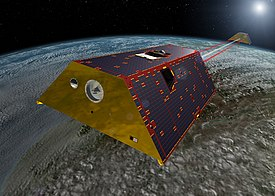





*   The Gravity Recovery and Climate Experiment (GRACE) was a joint mission of NASA and the German Aerospace Center (DLR). 
*   Twin satellites took detailed measurements of Earth's gravity field anomalies from its launch in March 2002 to the end of its science mission in October 2017. 
*    The GRACE Follow-On (GRACE-FO) is a continuation of the mission on near-identical hardware, launched in May 2018.
*    The first version of GRACE accomplished paramount scientific information related to oceanography, ice sheets, geodesy and geophysics among others.
*    GRACE’s key measurement, satellite gravimetry, uses a microwave ranging system to accurately measure changes in the speed and distance between two identical spacecraft, therefore formation flight is a key concept for this mission, moreover, it is the main technology behind the accuracy of the measurements


In [1]:
# Install the necessary dependencies
!pip install poliastro --quiet
!pip install tle-tools --quiet
!pip install sgp4 --quiet
!pip install --upgrade tbb --quiet

     |████████████████████████████████| 143 kB 26.3 MB/s 
     |████████████████████████████████| 4.5 MB 39.4 MB/s 
     |████████████████████████████████| 40 kB 4.7 MB/s 
     |████████████████████████████████| 832 kB 31.3 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.6 MB 49.4 MB/s 
     |████████████████████████████████| 258 kB 27.8 MB/s 
     |████████████████████████████████| 4.0 MB 29.1 MB/s 


In [2]:
# Import the dependencies and define basic credentials and variables

# Built-in modules
from base64 import b64decode
import numpy as np
import requests
from typing import Tuple

# Third-party packages
from astropy import units
from astropy.units.quantity import Quantity
from astropy.time import Time
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt
import plotly.io as pio
from poliastro.bodies import Earth
from poliastro.examples import iss
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter3D
from poliastro.twobody.orbit import Orbit
from sgp4.api import Satrec
from tletools import TLE
from typing import List, Tuple

# Set plotly renderer to Google Colab for 3D visualization
pio.renderers.default = "colab"

# Define credentials and uri variables
uriBase                = "https://www.space-track.org"
requestLogin           = "/ajaxauth/login"
requestCmdAction       = "/basicspacedata/query"
username = b'Y2dhbGxlZ285NjJAaG90bWFpbC5jb20='
password = b'Y2FybG9zMTIzNDU2Nzg5'
siteCred = {
    'identity': b64decode(username).decode("utf-8"), 
    'password': b64decode(password).decode("utf-8")
    }

custom_req = "/class/tle/NORAD_CAT_ID/{}/orderby/EPOCH%20desc/limit/{}/format/tle"

class HTTPError(Exception):
    # Custom exception for HTTP requests
    def __init___(self,args):
        Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
        self.args = args



Define auxiliary functions:



*   query_satellite_by_id: Gets TLEs by sending HTTP request to space-track API
*   get_orbits_from_tles: Converts TLEs objects to poliastro orbits
*   calculate_distance_between_satellites: Returns distances between satellites measured for specified epochs
*   plot_distance_between_satellites: plotting function



In [3]:
def query_satellite_by_id(name: str, sat_id: int, *, limit: int = 1) -> Tuple[List[TLE], List[Satrec]]:
    """Generates TLE and Satrec objects by providing name and id of the satellite.
    It does so by sending an HTTP request to space-track API.

    Args:
        name (str): name of the satellite
        sat_id (int): id of the satellite
        limit (int): number of entries to retrieve

    Raises:
        HTTPError: HTTP request failed

    Returns:
        TLE: Data class representing a single TLE.

        A two-line element set (TLE) is a data format encoding a list of orbital
        elements of an Earth-orbiting object for a given point in time, the epoch.

        All the attributes parsed from the TLE are expressed in the same units that
        are used in the TLE format.

        Satrec: Data class representing the satellite
    """
    TLEs = []
    Satrecs = []
    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit

        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        resp = session.post(uriBase + requestLogin, data = siteCred)
        if resp.status_code != 200:
            raise HTTPError(resp, "POST fail on login")

        # this query picks up the satellites from the catallogue with the corresponding sat_id.
        # Note - a 401 failure shows you have bad credentials
        uri = uriBase + requestCmdAction + custom_req.format(sat_id, limit)
        resp = session.get(uri)
        if resp.status_code != 200:
            print(resp)
            raise HTTPError(resp, "GET fail on request for Starlink satellites")

        response = resp.content.decode().splitlines()
        for line in range(int(len(response)/2)):
            line1 = response.pop(0)
            line2 = response.pop(0)
            TLEs.append(TLE.from_lines(name, line1, line2))
            Satrecs.append(Satrec.twoline2rv(line1, line2))

        return TLEs, Satrecs

def get_orbits_from_tles(tles_1: List[TLE], tles_2: List[TLE]) -> Tuple[List[Orbit], List[Orbit]]:
    """Receives a list of TLEs and outputs the corresponding
    poliastro Orbit objects.

    Args:
        tles_1 (List[TLE]): list of TLEs instances
        tles_2 (List[TLE]): list of TLEs instances

    Returns:
        List[Orbit]: list of poliastro.twobody.orbit.Orbit instances
    """
    orbits_1 = []
    orbits_2 = []

    # Convert TLE objects to orbits and append to orbits list
    for i in range(len(tles_1)):
        orbit_1 = tles_1[i].to_orbit()
        orbit_2 = tles_2[i].to_orbit()

        if orbit_1.epoch > orbit_2.epoch:
            deltaT = orbit_1.epoch - orbit_2.epoch
            orbit_2 = orbit_2.propagate(deltaT.to(units.s))
        else:
            deltaT = orbit_2.epoch - orbit_1.epoch
            orbit_1 = orbit_1.propagate(deltaT.to(units.s))

        orbits_1.append(orbit_1)
        orbits_2.append(orbit_2)

    return orbits_1, orbits_2

def calculate_distance_between_satellites(sat_1: List[Satrec], sat_2: List[Satrec], epochs: List[Time], step_size: int = 100) -> Tuple[list, list, list]:
    """Takes two satellites as inputs and returns two vectors containing the
    keplerian distances between the two objects and the instances where those
    distances were evaluated

    Args:
        sat_1 (Satrec): orbit instance of the first satellite
        sat_2 (Satrec): orbit instance of the second satellite
        epochs (astropy.Time): epochs to define limits for satellites
        step_size (int): step_size to divide the orbit period

    Returns:
        Tuple[list, list]: distances and corresponding time frames
    """

    distances = []
    distances_uncorrected = []
    frames = []
    jd1_epochs = [epoch.jd1 for epoch in epochs]
    jd2_epochs = [epoch.jd2 for epoch in epochs]
    init_epoch = epochs[0].unix
    for k, epoch in enumerate(epochs):
        try:
            step = (epochs[k+1]-epochs[k])/step_size
        except:
            pass
        for i in range(step_size):
            iter_epoch = epochs[k] + step*i
            iter_jd1 = iter_epoch.jd1
            iter_jd2 = iter_epoch.jd2
            _, r1, _ = sat_1[k].sgp4(iter_jd1, iter_jd2)
            _, r2, _ = sat_2[k].sgp4(iter_jd1, iter_jd2)
            _, r1_uncorrected, _ = sat_1[0].sgp4(iter_jd1, iter_jd2)
            _, r2_uncorrected, _ = sat_2[0].sgp4(iter_jd1, iter_jd2)
            distance = np.sqrt((r1[0]-r2[0])**2+(r1[1]-r2[1])**2+(r1[2]-r2[2])**2)
            distance_uncorrected = np.sqrt((r1_uncorrected[0]-r2_uncorrected[0])**2+(r1_uncorrected[1]-r2_uncorrected[1])**2+(r1_uncorrected[2]-r2_uncorrected[2])**2)
            distances.append(distance)
            distances_uncorrected.append(distance_uncorrected)
            frames.append((iter_epoch.unix-init_epoch)/3600)

    return (distances, distances_uncorrected, frames)

def plot_distance_between_satellites(distances: list, distances_uncorrected: list, frames: list, fmt: str = "svg") -> None:
    """Takes a list of distances and frames and plots the distance between 
    the two satellites in time

    Args:
        distances (list): distances between satellites
        frames (list): time ticks corresponding to those distances
    """
    with quantity_support():
        plt.figure(figsize=(10,6))
        plt.title('Distance between satellites', fontsize=20)
        plt.xlabel('Elapsed time (h)', fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Distance (km)', fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.plot(frames, distances)
        plt.plot(frames, distances_uncorrected)
        plt.savefig(f'distance.{fmt}', format=fmt)
       
    difference = [(a-b)*1000 for a,b in zip(distances,distances_uncorrected)]
    with quantity_support():
      plt.figure(figsize=(10,6))
      plt.title('Difference when updating with new TLE', fontsize=20)
      plt.xlabel('Elapsed time (h)', fontsize=16)
      plt.xticks(fontsize=16)
      plt.ylabel('Distance (m)', fontsize=16)
      plt.yticks(fontsize=16)
      plt.grid(True)
      plt.plot(frames, difference)
      plt.savefig(f'distance.{fmt}', format=fmt)

Get satellites TLEs from space-track API

In [4]:
grace_1_tles, grace_1_satrecs = query_satellite_by_id("GRACE-FO1", 43476, limit=100)
grace_2_tles, grace_2_satrecs = query_satellite_by_id("GRACE-FO2", 43477, limit=100)
example_tle = grace_1_tles[0] 
print(example_tle)

TLE(name='GRACE-FO1', norad='43476', classification='U', int_desig='18047A', epoch_year=2022, epoch_day=60.1027425, dn_o2=1.305e-05, ddn_o6=0.0, bstar=5.1599e-05, set_num=999, inc=88.9815, raan=53.1793, ecc=0.0019171, argp=52.4641, M=307.8345, n=15.24492263, rev_num=20990)


Retrieve keplerian elements

In [5]:
print(f"Eccentricity -> {example_tle.ecc:.6f}")
print(f"Inclintation -> {example_tle.inc:.2f} deg")
print(f"Semi-major axis -> {example_tle.a:.1f} km")
print(f"Right ascension of the ascending node -> {example_tle.raan:.2f} deg")
print(f"Argument of periapsis -> {example_tle.argp:.2f} deg")
print(f"True anomaly -> {example_tle.nu:.2f} deg")

Eccentricity -> 0.001917
Inclintation -> 88.98 deg
Semi-major axis -> 6870.4 km
Right ascension of the ascending node -> 53.18 deg
Argument of periapsis -> 52.46 deg
True anomaly -> -52.34 deg


Get orbits from TLEs

In [6]:
grace_1_orbits, grace_2_orbits = get_orbits_from_tles(grace_1_tles, grace_2_tles)
example_orbit = grace_1_orbits[0]
print(example_orbit)

6857 x 6884 km x 89.0 deg (GCRS) orbit around Earth (♁) at epoch 2022-03-01T02:28:23.464704000 (UTC)


Sample position and velocity of the Orbit. Example of simple propagation

In [7]:
print("Position and velocity for instant t = t0\n")
pos, vel = example_orbit.rv()
print(pos)
print(vel)
print("\n")
print("Position and velocity for instant t = t1; t1 = t0 + 1 sec\n")
example_orbit_2 = example_orbit.propagate(1*units.s)
pos2, vel2 = example_orbit_2.rv()
print(pos2)
print(vel2)

Position and velocity for instant t = t0

[4107.38568984 5492.76123318  217.06197083] km
[-0.25981513 -0.12097791  7.62076059] km / s


Position and velocity for instant t = t1; t1 = t0 + 1 sec

[4107.12334135 5492.63686739  224.68259596] km
[-0.26488181 -0.12775366  7.62048812] km / s


Calculate distance between TLEs

In [8]:
epochs = [orbit.epoch for orbit in grace_1_orbits][::-1]
distances, uncorrected_distances, frames = calculate_distance_between_satellites(grace_1_satrecs, grace_2_satrecs, epochs, step_size=500)

Plot distances

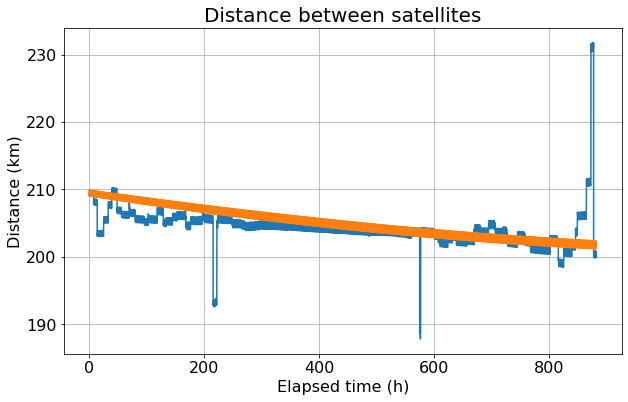

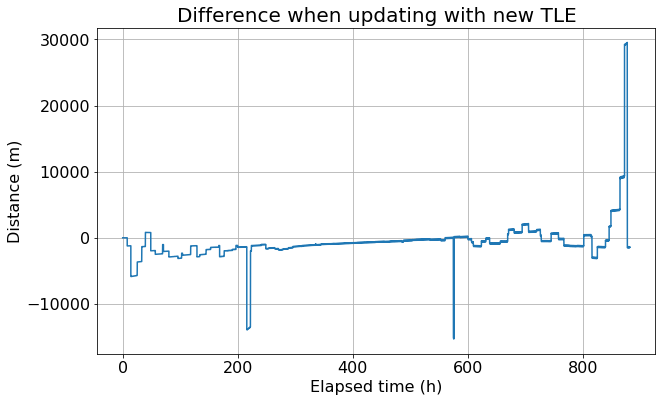

In [9]:
plot_distance_between_satellites(distances, uncorrected_distances, frames, fmt="svg")

Plot Orbits in 3D

In [10]:
equatorial = Orbit.circular(Earth, 0*units.km)

frame = OrbitPlotter3D(dark=True, plane=Planes.EARTH_EQUATOR)
frame.set_view(elev=15*units.deg, azim=45*units.deg, distance=1.6*units.km)
frame.plot(grace_1_orbits[0], label="GRACE-FO1", color="purple")
frame.plot(grace_2_orbits[0], label="GRACE-FO2", color="white")
frame.plot(iss, label="ISS", color="orange")
frame.plot(equatorial, label="Equator", color="grey")


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



# Main conclusions



*   Since the error of propagating a single TLE grows with time, the importance of constantly retriving data to generate new TLEs and keep the catalogue updated is paramount in order to be able to accurately track orbiting objects.
*   Single TLEs must be put in perspective with the history of the rest of TLEs available, and their accuracy should be double-checked to avoid drawing premature conclusions.



# References

[1]  Kelsey Cranford. “An improved analytical drag theory for the artificial satellite problem”. In:1969.

[2]  “Space Track API”. In:url:https://www.space-track.org/.

[3]  Travis E. Oliphant. “Python for Scientific Computing”. In:Computing in Science Engineering9.3 (2007), pp. 10–20.doi:10.1109/MCSE.2007.58.

[4]  NASA. “Prolific Earth Gravity Satellites End Science Mission”. In:Jet Propulsion LaboratoryNews(Oct. 27, 2017).url:https://www.jpl.nasa.gov/news/prolific-earth-gravity-satellites-end-science-mission.

[5]  NASA. “GRACE Mission: 15 Years of Watching Water on Earth”. In:Jet Propulsion LaboratoryNews(Mar. 15, 2017).url:https://www.jpl.nasa.gov/news/grace-mission-15-years-of-watching-water-on-earth.

[6]  Krzysztof Sośnica et al. “Time variable Earth’s gravity field from SLR satellites”. In:Journal ofGeodesy89 (Oct. 2015).doi:10.1007/s00190-015-0825-1.

[7]  NASA. “Grace Space Twins set to team up to track Earth’s water and gravity”. In: (Mar. 7,2002).url:https://www.jpl.nasa.gov/news/press_kits/gracelaunch.pdf.

[8]  David Vallado et al. “Revisiting Spacetrack Report #3”. In:AIAA/AAS Astrodynamics Special-ist Conference and Exhibit.doi:10.2514/6.2006-6753. eprint:https://arc.aiaa.org/doi/pdf/10.2514/6.2006-6753.url:https://arc.aiaa.org/doi/abs/10.2514/6.2006-6753.

[9]  “TLE-tools package”. In:url:https://pypi.org/project/TLE-tools/.

[10]  “sgp4 package”. In:url:https://pypi.org/project/sgp4/.